In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split
import warnings
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Reading dataset as dataframe

df_img = pd.read_csv('./../data/cleaned/ferplus.csv')
df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,30,24,21,23,25,25,49,67,84,103,...,106,111,148,137,176,174,172,173,173,anger
1,123,125,124,142,209,226,234,236,231,232,...,103,116,111,105,105,103,97,91,89,anger
2,236,230,225,226,228,209,199,193,196,211,...,192,190,186,171,144,144,152,155,173,anger
3,255,82,0,3,0,0,0,0,0,0,...,101,217,255,198,143,236,254,254,254,anger
4,206,208,209,212,214,216,216,219,221,222,...,38,42,50,47,26,31,29,40,5,anger


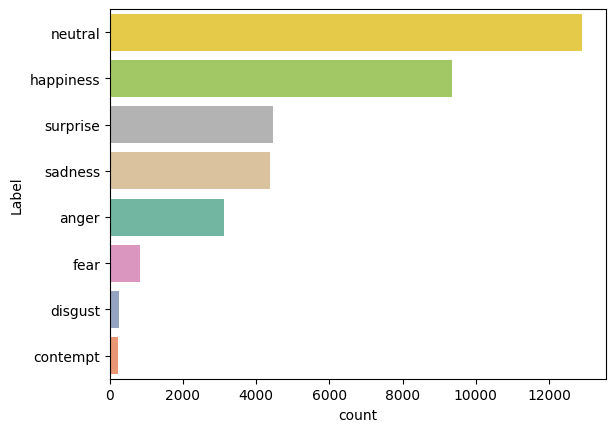

In [4]:
# Checking how many images we have for each label

counts = df_img['Label'].value_counts().sort_values(ascending=False)

sns.countplot(y=df_img['Label'], hue=df_img['Label'], order=counts.index, palette='Set2')
plt.show()

In [5]:
def normalize(value):
    return value/255

pixel_cols = [col for col in df_img.columns if 'Pixel' in col]

for col in pixel_cols:
    df_img[col].astype(float)

df_img.iloc[:, :-1] = df_img.iloc[:, :-1].apply(normalize)

df_img.head()

,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,...,Pixel_2296,Pixel_2297,Pixel_2298,Pixel_2299,Pixel_2300,Pixel_2301,Pixel_2302,Pixel_2303,Pixel_2304,Label
0,0.117647,0.094118,0.082353,0.090196,0.098039,0.098039,0.192157,0.262745,0.329412,0.403922,...,0.415686,0.435294,0.580392,0.537255,0.690196,0.682353,0.674510,0.678431,0.678431,anger
1,0.482353,0.490196,0.486275,0.556863,0.819608,0.886275,0.917647,0.925490,0.905882,0.909804,...,0.403922,0.454902,0.435294,0.411765,0.411765,0.403922,0.380392,0.356863,0.349020,anger
2,0.925490,0.901961,0.882353,0.886275,0.894118,0.819608,0.780392,0.756863,0.768627,0.827451,...,0.752941,0.745098,0.729412,0.670588,0.564706,0.564706,0.596078,0.607843,0.678431,anger
3,1.000000,0.321569,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396078,0.850980,1.000000,0.776471,0.560784,0.925490,0.996078,0.996078,0.996078,anger
4,0.807843,0.815686,0.819608,0.831373,0.839216,0.847059,0.847059,0.858824,0.866667,0.870588,...,0.149020,0.164706,0.196078,0.184314,0.101961,0.121569,0.113725,0.156863,0.019608,anger


In [6]:
labels = df_img['Label'].unique().tolist()

mapping_dict = dict(zip(labels, range(8)))

df_img['Label'] = df_img['Label'].replace(mapping_dict)

df_img['Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [7]:
# Splitting dataset into X and y

X = df_img.drop(columns='Label')
y = df_img['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train_np = np.array(X_train).reshape((-1, 48, 48, 1))
y_train_np = np.array(y_train)
X_test_np = np.array(X_test).reshape((-1, 48, 48, 1))
y_test_np = np.array(y_test)

X_train_np = np.repeat(X_train_np, 3, axis=-1)
X_test_np = np.repeat(X_test_np, 3, axis=-1)

# Assuming y_train contains the class labels for your training data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
# Load MobileNetV2 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Create your model on top of MobileNetV2 base
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))  # Assuming 8 classes for classification

# Freeze the pre-trained layers of MobileNetV2
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer='Adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 23,851,016
Trainable params: 23,797,896
Non-trainable params: 53,120
_________________________________________________________________


Epoch 1/50
710/710 - 38s - loss: 1.0796 - accuracy: 0.6350 - val_loss: 1.7349 - val_accuracy: 0.4274 - lr: 0.0010 - 38s/epoch - 53ms/step
Epoch 2/50
710/710 - 29s - loss: 0.8243 - accuracy: 0.7151 - val_loss: 1.2252 - val_accuracy: 0.6620 - lr: 0.0010 - 29s/epoch - 41ms/step
Epoch 3/50
710/710 - 29s - loss: 0.7143 - accuracy: 0.7528 - val_loss: 0.9737 - val_accuracy: 0.6400 - lr: 0.0010 - 29s/epoch - 40ms/step
Epoch 4/50
710/710 - 30s - loss: 0.6392 - accuracy: 0.7776 - val_loss: 0.9050 - val_accuracy: 0.6819 - lr: 0.0010 - 30s/epoch - 42ms/step
Epoch 5/50
710/710 - 28s - loss: 0.5562 - accuracy: 0.8053 - val_loss: 0.9478 - val_accuracy: 0.6648 - lr: 0.0010 - 28s/epoch - 39ms/step
Epoch 6/50
710/710 - 29s - loss: 0.4894 - accuracy: 0.8283 - val_loss: 1.0397 - val_accuracy: 0.6515 - lr: 0.0010 - 29s/epoch - 40ms/step
Epoch 7/50
710/710 - 28s - loss: 0.4043 - accuracy: 0.8549 - val_loss: 1.1320 - val_accuracy: 0.6791 - lr: 0.0010 - 28s/epoch - 40ms/step
Epoch 8/50

Epoch 8: ReduceLROnPla

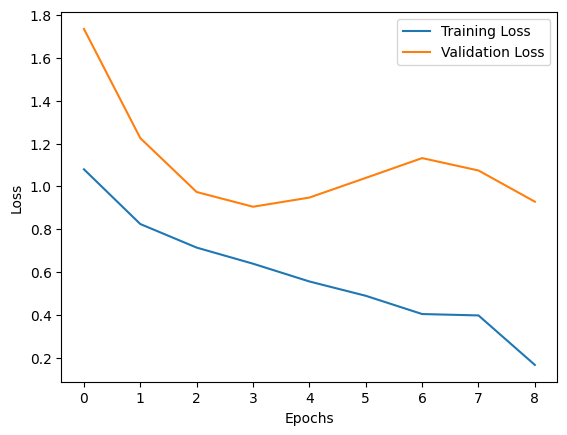

In [9]:
model_path = './../models/ResNet50_model.h5'

callbacks = [EarlyStopping(patience=5, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=4, verbose=1),
             ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')]

# Fitting

history = model.fit(X_train_np, y_train_np, epochs=50, batch_size=32, validation_split=0.2, verbose=2, callbacks=callbacks)

# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

222/222 [==============================] - 4s 13ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       607
           1       0.23      0.67      0.34        15
           2       0.28      0.61      0.38        23
           3       0.45      0.54      0.49       136
           4       0.84      0.89      0.86      1759
           5       0.83      0.76      0.79      2845
           6       0.54      0.60      0.57       783
           7       0.81      0.78      0.80       929

    accuracy                           0.76      7097
   macro avg       0.58      0.69      0.61      7097
weighted avg       0.77      0.76      0.77      7097

Cohen-Kappa score: 0.6864227687077233


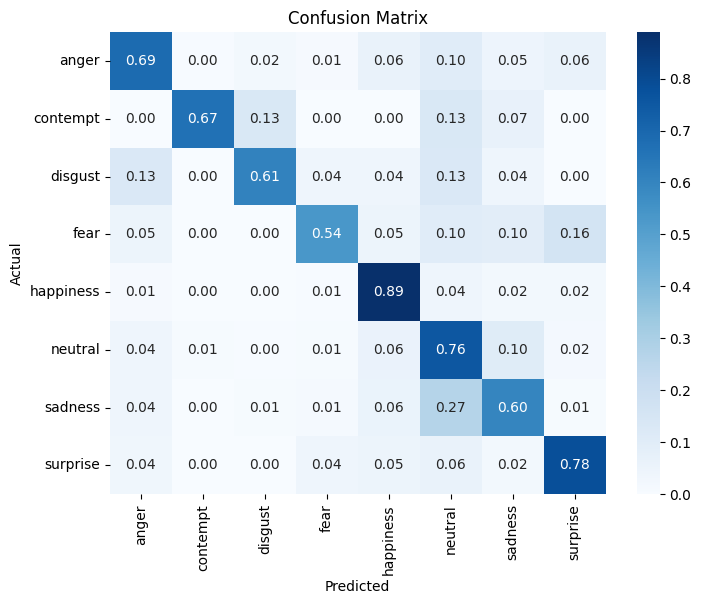

In [10]:
# Performance metrics on test set

y_pred_proba = model.predict(X_test_np)

y_pred = [np.argmax(x) for x in y_pred_proba]

cr = classification_report(y_pred, y_test)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred, y_test)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred, y_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()